# Inttroduction
In this project we will compare 4 hyperparameter tuning methods:
1. GridSearchCV
2. RandomizedSearchCV
3. BayesSearchCV
4. Optuna

By th end of this projects, RMSE produced by each method, learning curve, and indication of overfitting/underfitting will be analyzed. This project should be a good demonstration of how each method might benefit us and under what circumstances.

### Import Libraries

In [ ]:
!pip install scikit-optimize
!pip install optuna

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Import Model Machine Learning Regressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

#Evaluasi Model
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

#Hyperparameter Tunning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import optuna

#Masukkan libraries lain jika dibutuhkan

#1. Load CSV data

In [ ]:
df=pd.read_csv('1699057012240-california_dataset.csv')

#2. Drop Latitude and Longitude

In [ ]:
df = df.drop(['Latitude', 'Longitude'], axis=1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,house_price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


#3. Check whether there are any NaN or non float dtype

In [ ]:
for col in df.columns:
  print(df[col].isnull().any())
  print(df[col].dtype)

False
float64
False
float64
False
float64
False
float64
False
float64
False
float64
False
float64


#4. Check the skewness of the data

In [ ]:
from scipy.stats import skew

# Calculate skewness for each column
skewness = df.apply(lambda x: skew(x, nan_policy='omit'))

# 'skewness' is a Pandas Series with skewness values
print(skewness)

MedInc          1.646537
HouseAge        0.060326
AveRooms       20.696365
AveBedrms      31.314680
Population      4.935500
AveOccup       97.632465
house_price     0.977692
dtype: float64


From results above we can see some indication of outliers. IQR Handling will be done here before we proceed further for the standard scaling.

#5. IQR Handling

In [ ]:
def find_outlier_boundary(df, variable):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

for col in [df.columns]:
  upper_limit, lower_limit = find_outlier_boundary(df, col)
  df[col]= np.where(df[col] > upper_limit, upper_limit,
                       np.where(df[col] < lower_limit, lower_limit, df[col]))
# Calculate skewness for each column
skewness = df.apply(lambda x: skew(x, nan_policy='omit'))
# 'skewness' is a Pandas Series with skewness values
print(skewness)

MedInc         0.735565
HouseAge       0.060326
AveRooms       0.348541
AveBedrms      0.462611
Population     0.842186
AveOccup       0.510416
house_price    0.912264
dtype: float64


The skewness has reached a tolerable level in order for us to be able to safely standardize with standard scaler.

#6. Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

#separate features from the target, scaling will only be done on the features
x=df.copy()
y=x.pop('house_price')

#scale the features
standard_scaler=StandardScaler()
x_scaled=standard_scaler.fit_transform(x)
x_scaled=pd.DataFrame(x_scaled,columns=x.columns,index=x.index)
print(x_scaled.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  2.064000e+04  2.064000e+04  2.064000e+04  2.064000e+04  2.064000e+04   
mean  -7.711317e-17  5.508083e-18  2.478637e-16 -6.857564e-16  1.335710e-16   
std    1.000024e+00  1.000024e+00  1.000024e+00  1.000024e+00  1.000024e+00   
min   -1.991479e+00 -2.196180e+00 -2.633335e+00 -2.387314e+00 -1.742525e+00   
25%   -7.466196e-01 -8.453931e-01 -6.933564e-01 -6.448912e-01 -7.184008e-01   
50%   -1.605978e-01  2.864572e-02 -6.067586e-02 -1.140809e-01 -2.233204e-01   
75%    5.684305e-01  6.643103e-01  5.999626e-01  5.167240e-01  5.068904e-01   
max    2.541006e+00  1.856182e+00  2.539941e+00  2.259147e+00  2.344827e+00   

           AveOccup  
count  2.064000e+04  
mean  -1.156697e-16  
std    1.000024e+00  
min   -2.530199e+00  
25%   -6.799133e-01  
50%   -1.179684e-01  
75%    5.536104e-01  
max    2.403896e+00  


#7. Lasso Baseline Model

In [ ]:
#preparing train and test data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

#creating baseline model
lasso_model = Lasso(random_state=42) #Lasso
lasso_model.fit(x_train, y_train)

Lasso(random_state=42)

#8. Baseline Prediction

In [ ]:
#try to predict training rmse using baseline model
y_train_pred_lasso = lasso_model.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using baseline model
y_pred_lasso = lasso_model.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 1.1340426341838947
RMSE on Testing Data (Lasso): 1.1245508304576213


In [ ]:
print(y_train.describe())
print(y_test.describe())

count    16512.000000
mean         2.063027
std          1.134077
min          0.149990
25%          1.198000
50%          1.798500
75%          2.651250
max          4.824125
Name: house_price, dtype: float64
count    4128.000000
mean        2.046952
std         1.124572
min         0.149990
25%         1.192750
50%         1.786500
75%         2.630000
max         4.824125
Name: house_price, dtype: float64


With target mean of ~2.06, after applying feature scaling our RMSE doesn't look very good. But we shall see what happen when we apply hyperparameter tuning.

#9.a. Hyperparameter Tuning: Grid Search

In [ ]:
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],
    'tol': [0.0001, 0.001, 0.01],
    'selection': ['cyclic','random'],
    'fit_intercept':[False, True]
}

grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
print("Parameter Terbaik:", grid_search.best_params_)

Parameter Terbaik: {'alpha': 0.1, 'fit_intercept': True, 'selection': 'random', 'tol': 0.001}


In [ ]:
lasso_grid_best = Lasso(**grid_search.best_params_,random_state=42)
lasso_grid_best.fit(x_train, y_train)

Lasso(alpha=0.1, random_state=42, selection='random', tol=0.001)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_grid_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_grid_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7601621091478021
RMSE on Testing Data (Lasso): 0.7695423553996351


Significant decrease in RMSE from ~1.1 to ~0.76 was observed. With the similarity between training and test RMSE, the model seems to be good (not underfitting/overfitting). Let's confirm this with the learning curve.

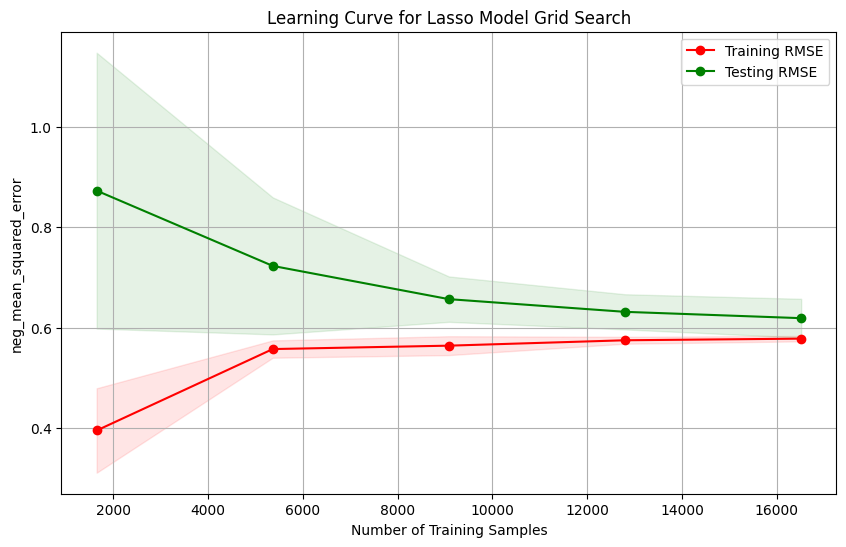

In [ ]:
def plot_learning_curve(model, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of Training Samples")
    plt.ylabel("neg_mean_squared_error")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing RMSE")

    plt.legend(loc="best")
    plt.show()
plot_learning_curve(lasso_grid_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Grid Search")

The rmse curve for training and test predictions converged. This means that no overfitting or underfitting has occured.

#9.b. Hyperparameter Tuning: Random Search

In [ ]:
random_search = RandomizedSearchCV(lasso_model, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=10)
random_search.fit(x_train, y_train)
print("Parameter Terbaik:", random_search.best_params_)

Parameter Terbaik: {'tol': 0.0001, 'selection': 'random', 'fit_intercept': True, 'alpha': 0.1}


In [ ]:
lasso_random_best = Lasso(**random_search.best_params_,random_state=42)
lasso_random_best.fit(x_train, y_train)

Lasso(alpha=0.1, random_state=42, selection='random')

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_random_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_random_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.760167111489467
RMSE on Testing Data (Lasso): 0.7695470772577261


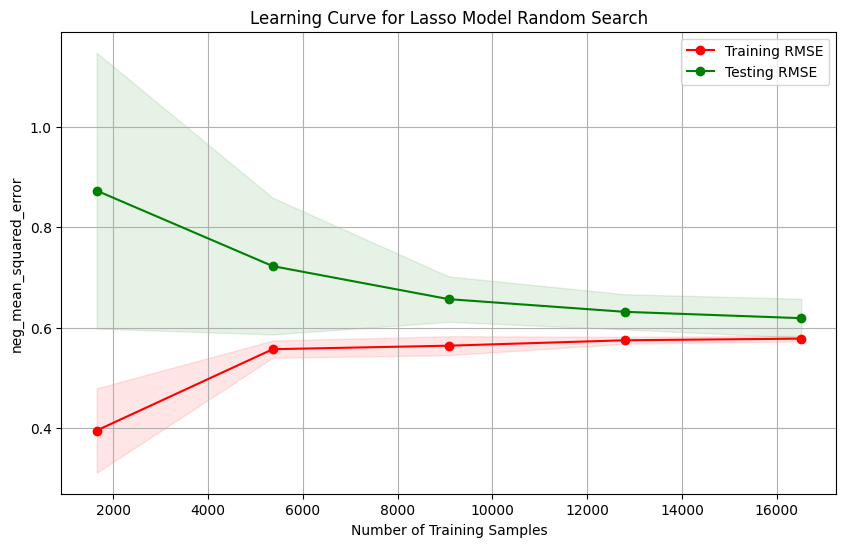

In [ ]:
plot_learning_curve(lasso_random_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Random Search")

Same case with grid search, although grid search produced marginally lower RMSE. This is to be expected. Take a look again at our parameter grid. We have 48 possible combinations. <br><br>
param_grid = {
    'alpha': [0.1, 1.0, 5.0, 10.0],
    'tol': [0.0001, 0.001, 0.01],
    'selection': ['cyclic','random'],
    'fit_intercept':[False, True]
}<br><br>
While grid search checks all those 48 combinations, random search only checks 10 random combinations in our case. This is why our grid search happened to find the best combination deterministically. See below for comparison between grid and random result.
<br><br>
Grid:<br>
RMSE on Training Data (Lasso): 0.7601621091478021<br>
RMSE on Testing Data (Lasso): 0.7695423553996351<br><br>
Random:<br>
RMSE on Training Data (Lasso): 0.760167111489467<br>
RMSE on Testing Data (Lasso): 0.7695470772577261

#9.c. Hyperparameter Tuning: Bayesian Search

In [ ]:
bayes_search = BayesSearchCV(
    estimator=lasso_model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=10,
    n_jobs=-1 #set to -1 to ensure using max amount of CPU cores
)

bayes_search.fit(x_train,y_train)
print("Parameter Terbaik:", bayes_search.best_params_)

Parameter Terbaik: OrderedDict([('alpha', 0.1), ('fit_intercept', True), ('selection', 'random'), ('tol', 0.001)])


In [ ]:
lasso_bayes_best = Lasso(**bayes_search.best_params_,random_state=42)
lasso_bayes_best.fit(x_train, y_train)

Lasso(alpha=0.1, random_state=42, selection='random', tol=0.001)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_bayes_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_bayes_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7601621091478021
RMSE on Testing Data (Lasso): 0.7695423553996351


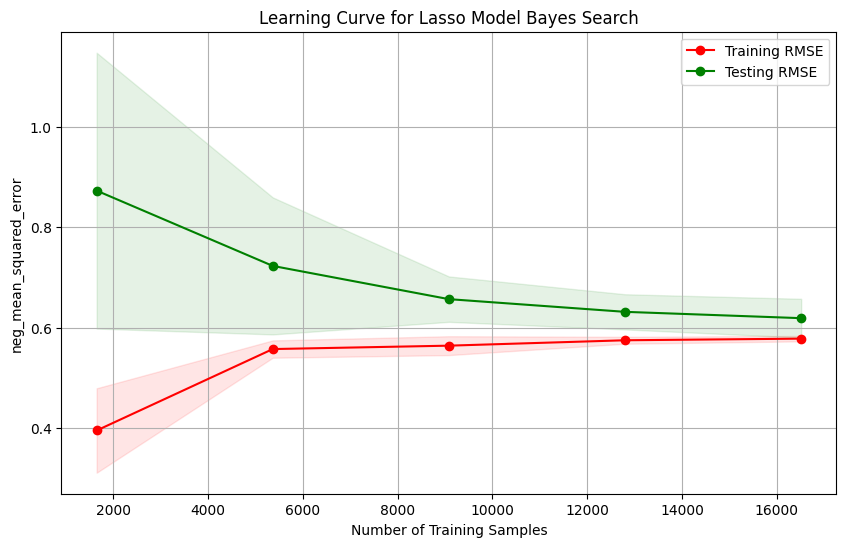

In [ ]:
plot_learning_curve(lasso_bayes_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Bayes Search")

Interesting finding here is that with only 10 number of iterations, we managed to find RMSE that is as low as from grid search. This is because bayes search look for the best combination in a manner that consider which combination is most likely to give the best result. While we may have just got lucky that our bayes search is doing well, this particular finding has demonstrated how bayes search is able to combine the fast computation of random search with the high performance of grid search.

See below for comparison between grid and bayes result. Both produced the same result.
<br><br>
Grid:<br>
RMSE on Training Data (Lasso): 0.7601621091478021<br>
RMSE on Testing Data (Lasso): 0.7695423553996351<br><br>
Bayes:<br>
RMSE on Training Data (Lasso): 0.7601621091478021<br>
RMSE on Testing Data (Lasso): 0.7695423553996351<br><br>

#9.d. Hyperparameter Tuning: Optuna

In [ ]:
def objective(trial):
  alpha = trial.suggest_float('alpha', 0.1, 10.0, log=True)
  tol = trial.suggest_float('tol', 1e-4, 1e-2, log=True)
  selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
  fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
  lasso = Lasso(alpha=alpha, tol=tol, selection=selection, fit_intercept=fit_intercept)
  lasso.fit(x_train, y_train)
  y_pred = lasso.predict(x_test)
  return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(f"Best Parameters: {study.best_params}")
print(f"Best Mean Squared Error: {study.best_value}")

[I 2023-11-07 11:44:01,057] A new study created in memory with name: no-name-23172182-e3f7-45c9-b91b-f5f4e3347918
[I 2023-11-07 11:44:01,074] Trial 0 finished with value: 5.454367777646584 and parameters: {'alpha': 7.995515225028576, 'tol': 0.0002162942662338409, 'selection': 'cyclic', 'fit_intercept': False}. Best is trial 0 with value: 5.454367777646584.
[I 2023-11-07 11:44:01,096] Trial 1 finished with value: 0.8524202296653216 and parameters: {'alpha': 0.42987828752256024, 'tol': 0.0009455257335561833, 'selection': 'cyclic', 'fit_intercept': True}. Best is trial 1 with value: 0.8524202296653216.
[I 2023-11-07 11:44:01,122] Trial 2 finished with value: 0.748796253743561 and parameters: {'alpha': 0.27792720418160705, 'tol': 0.0004076105706176232, 'selection': 'cyclic', 'fit_intercept': True}. Best is trial 2 with value: 0.748796253743561.
[I 2023-11-07 11:44:01,145] Trial 3 finished with value: 1.003151893494368 and parameters: {'alpha': 0.5872141992666946, 'tol': 0.00039790594861021

Best Parameters: {'alpha': 0.12584118787380605, 'tol': 0.001423654505098192, 'selection': 'random', 'fit_intercept': True}
Best Mean Squared Error: 0.609412300850976


In [ ]:
lasso_optuna_best = Lasso(**study.best_params,random_state=42)
lasso_optuna_best.fit(x_train, y_train)

Lasso(alpha=0.12584118787380605, random_state=42, selection='random',
      tol=0.001423654505098192)

In [ ]:
#try to predict training rmse using best lasso parameters
y_train_pred_lasso = lasso_optuna_best.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))

#try to predict test rmse using best lasso parameters
y_pred_lasso = lasso_optuna_best.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("RMSE on Training Data (Lasso):", rmse_train_lasso)
print("RMSE on Testing Data (Lasso):", rmse_test_lasso)

RMSE on Training Data (Lasso): 0.7722247178955333
RMSE on Testing Data (Lasso): 0.7806996563010256


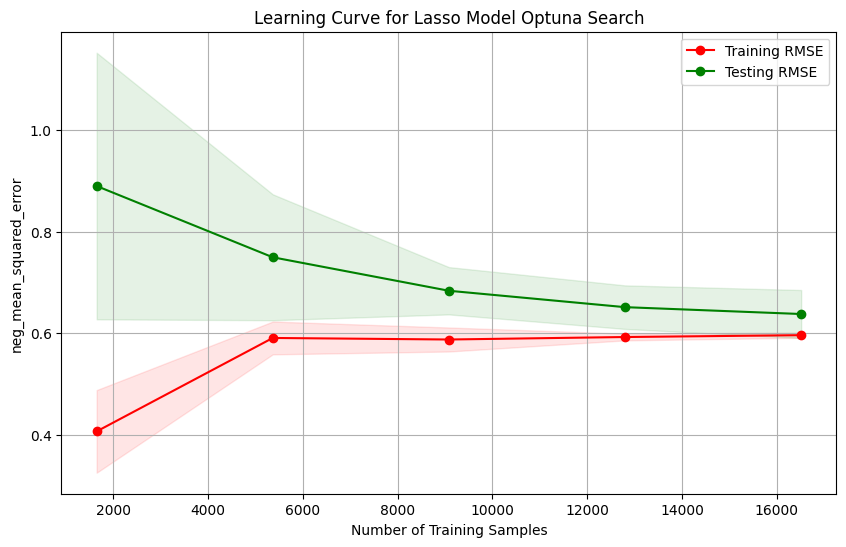

In [ ]:
plot_learning_curve(lasso_optuna_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Lasso Model Optuna Search")

Optuna tuning has also done very well although it produced the worst result of all tuning. The most likely cause is that because we only used 10 number of trials (or iterations) while Optuna, unlike other tuning method, checks the numerical parameters in a continous manner. This means that while our other method managed to find alpha=0.1 as the best parameter, Optuna is stuck with alpha=anything between 0.1 and 10, even though we apply log=True to prioritize smaller alpha.

#10. Conclusion

Let's recap our train/test RMSE results for each hyperparameter tuning.

a. Grid Search<br>
RMSE on Training Data (Lasso): 0.7601621091478021<br>
RMSE on Testing Data (Lasso): 0.7695423553996351<br><br>

b. Random Search<br>
RMSE on Training Data (Lasso): 0.760167111489467<br>
RMSE on Testing Data (Lasso): 0.7695470772577261<br><br>

c. Bayes Search<br>
RMSE on Training Data (Lasso): 0.7601621091478021<br>
RMSE on Testing Data (Lasso): 0.7695423553996351<br><br>

d. Optuna<br>
RMSE on Training Data (Lasso): 0.7722247178955333<br>
RMSE on Testing Data (Lasso): 0.7806996563010256<br>

It was observed that all tunings are equally good although Grid Search and Bayes Search produced marginally better result. Theoretically speaking, Optuna should have given the best result but it will require a lot of trials in order for it to find the best numerical data between alpha=0.1 and alpha=10.0. We were just lucky that with grid, random, and bayes, we initially guess alpha=0.1 which gives very good result. Random search is possibly the fastest among the three, but grid search has better stability while bayes search may give superior result in term of lower RMSE and faster speed if we are lucky.

#11. Additional Topic: Random Forest Regressor

One might wonder why our RMSE are still too big. The ideal result should be 0 and with the mean of our target value at ~2.06, it might worth to cross check using random forest regressor. Lasso is a model that implement L1 regularization, which means it is trying to prevent overfitting with a risk of underfitting if done on non-linear data. Random Forest Regressor on the other hand have a risk of overfitting but works better on non-linear data.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'max_depth': [None, 15, 10, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1,2,3,4]
}

rf_model = RandomForestRegressor(random_state=42) #RandomForestRegressor
rf_model.fit(x_train, y_train)
grid_search = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
print("Parameter Terbaik:", grid_search.best_params_)

Parameter Terbaik: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [ ]:
rf_grid_best = RandomForestRegressor(**grid_search.best_params_,random_state=42)
rf_grid_best.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [ ]:
#try to predict training rmse using best random forest parameters
y_train_pred_rf = rf_grid_best.predict(x_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))

#try to predict test rmse using best random forest parameters
y_pred_rf = rf_grid_best.predict(x_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("RMSE on Training Data (RF):", rmse_train_rf)
print("RMSE on Testing Data (RF):", rmse_test_rf)

RMSE on Training Data (RF): 0.5114830086475479
RMSE on Testing Data (RF): 0.6360946014782661


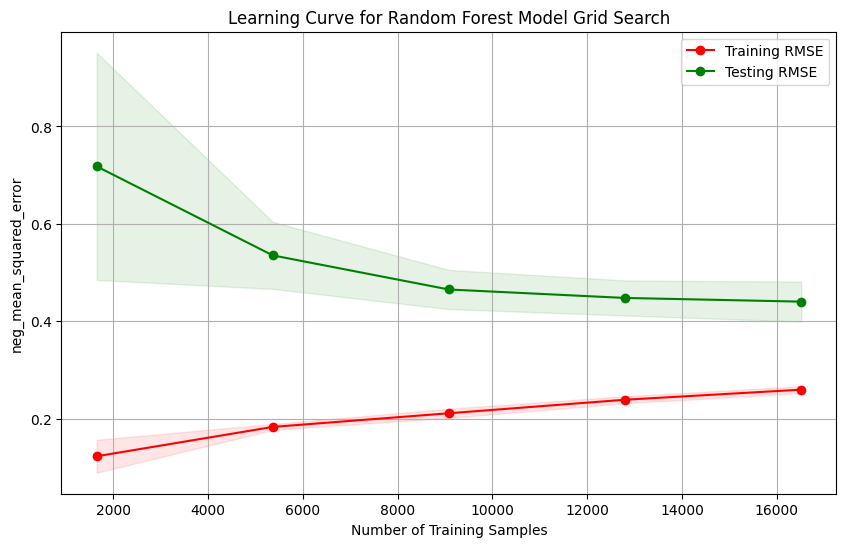

In [ ]:
plot_learning_curve(rf_grid_best, x_scaled, y, cv=5, scoring='neg_mean_squared_error', title="Learning Curve for Random Forest Model Grid Search")

As expected, while the RMSE produced with random forest regressor is lower compared to the other 4 tuning, it is the one with highest indicator of overfitting. Perhaps a more advanced technique that can provide better non-linearity such as deep neural network is needed, but for now our observation is good enough for demonstration of how powerful hyperparameter tuning can be. As a reminder, we went from:

Baseline model<br>
RMSE on Training Data (Lasso): 1.1340426341838947<br>
RMSE on Testing Data (Lasso): 1.1245508304576213<br><br>
to<br><br>
Random Forest Regressor (grid search)<br>
RMSE on Training Data (RF): 0.5114830086475479<br>
RMSE on Testing Data (RF): 0.6360946014782661<br><br>
So basically we managed to cut our RMSE by half.